# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. 
> Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. 

In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.

<img src="notebook_ims/vgg_16_architecture.png" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but **replace the final fully-connected layer** with our own classifier. This way we can use __VGGNet as a fixed feature extractor__ for our images then easily train a simple classifier on top of that. 
* Use all but the last fully-connected layer as a fixed feature extractor.
* Define a new, final classification layer and apply it to a task of our choice!

You can read more about transfer learning from [the CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/).

---

## Flower power

Here we'll be using VGGNet to classify images of flowers. We'll start, as usual, by importing our usual resources. And checking if we can train our model on GPU.

### Download Data

The flower data is available in a zip file in this lesson's resources, for download to your local environment. In the case of this notebook, the data is already downloaded and in the directory `flower_photos/`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import torchvision
from torchvision import datasets, models, transforms as T

In [4]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load and Transform our Data

We'll be using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class which makes is very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Where, in this case, the root folder for training is `flower_photos/train/` and the classes are the names of flower types.

In [5]:
# define training and test data directories
dir_images = 'flower_photos/'
dir_train = os.path.join(dir_images, 'train/')
dir_test = os.path.join(dir_images, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

In [6]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.ToTensor()
])

data_train = datasets.ImageFolder(dir_train, transform= data_transform)
data_test = datasets.ImageFolder(dir_test, transform= data_transform)

# print out some data stats
print('Num training images: ', len(data_train))
print('Num test images: ', len(data_test))

Num training images:  3130
Num test images:  540


### DataLoaders and Data Visualization

In [7]:
# define dataloader parameters
params_loader = {'batch_size': 32, 'num_workers': 0, 'shuffle': True}

# prepare data loaders
loader_train = torch.utils.data.DataLoader(data_train, **params_loader)
loader_test = torch.utils.data.DataLoader(data_test, **params_loader)

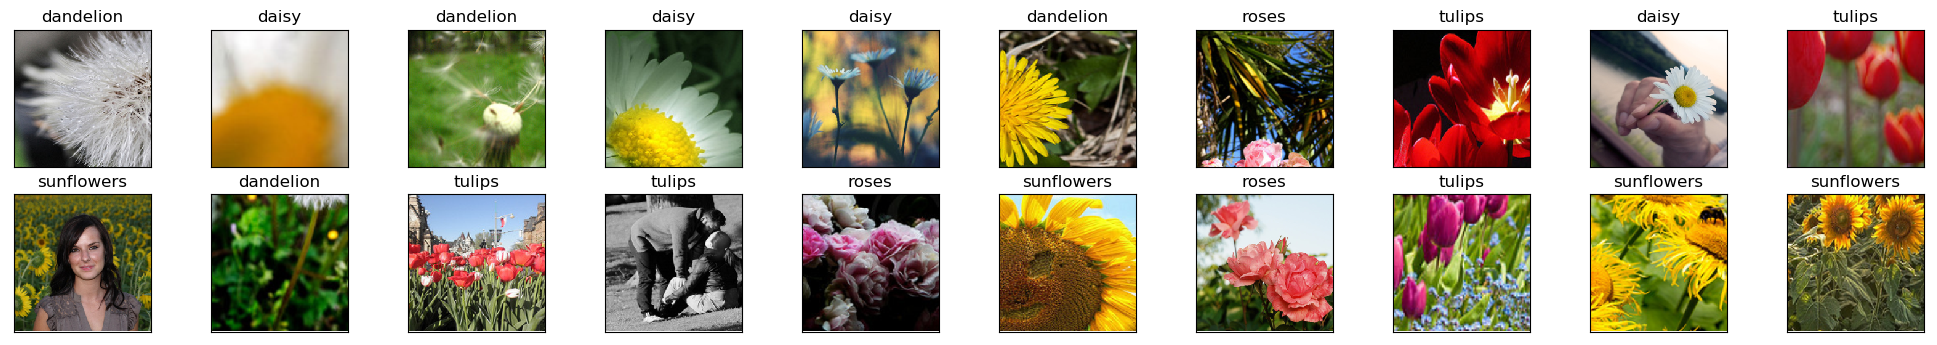

In [8]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(loader_train)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy()

# plot the first 20 images in the batch, along with the corresponding labels
fig = plt.figure(figsize= (25, 4), dpi= 100)
for ix in np.arange(20):
    ax = fig.add_subplot(2, 20/2, ix+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[ix], (1, 2, 0)))
    ax.set_title(classes[labels[ix]])

---
## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [9]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 115463037.29it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

As you see, __VGG16__ is consisted of two categories: 1. features 2. classifier    

The convolutional parts -- with pooling-- act as feature extracter, and the fully connected layers at the end of the network perform as the classifier.

In [10]:
# Get the number of inputs and outputs for the very last layer of VGG
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [11]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

---
### Final Classifier Layer

Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you replace the last layer in the vgg classifier group of layers. 
> This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

#### TODO: Replace the last fully-connected layer with one that produces the appropriate number of class scores.

In [12]:
# Get the number of inputs to the last layer of VGG
# We need this because, this is what the one-before-last layer will output
n_inputs = vgg16.classifier[6].in_features

# Add a last linear layer that maps n_inputs -> 5 flower classes
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 5)

# Replace the last layer in VGG16 with this layer defined for flower data
vgg16.classifier[6] = last_layer

In [13]:
# Make sure the last layer produces the expected number of outputs: 5
print(vgg16.classifier[6].out_features)

5


In [14]:
# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Below we'll use cross-entropy loss and stochastic gradient descent with a small learning rate. Note that the optimizer accepts as input _only_ the trainable parameters `vgg.classifier.parameters()`.

In [15]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent)
optimizer = optim.SGD(vgg16.classifier.parameters(), lr= 0.001)

---
## Training

In [16]:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs + 1):
    # keep track of training and validation loss
    loss_train = 0
    
    # train the model ====================================
    # Prep the model for training phase.
    vgg16.train()
    
    for batch_i, (data, target) in enumerate(loader_train, start= 1):
        # Move tensors to GPU if CUDA is available.
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # Run the forward pass ------
        # Clear the gradients.
        optimizer.zero_grad()
        # Get the model prediction, calculate the loss.
        output = vgg16(data)
        loss = criterion(output, target)
        # Compute gradient of the loss with respect to model parameters.
        loss.backward()
        # Update the parameters.
        optimizer.step()
        
        # Update training loss.
        loss_train += loss.item()
        
        # Print training loss every specified number of mini-batches
        if batch_i % 20 == 0:
            print('Epoch %d, Batch %d loss: %.16f' %
                  (epoch, batch_i + 1, loss_train / 20))
            loss_train = 0


Epoch 1, Batch 21 loss: 1.5664936065673829
Epoch 1, Batch 41 loss: 1.3880285441875457
Epoch 1, Batch 61 loss: 1.2372831642627715
Epoch 1, Batch 81 loss: 1.1399073064327241
Epoch 2, Batch 21 loss: 0.9906639665365219
Epoch 2, Batch 41 loss: 0.9503686696290969
Epoch 2, Batch 61 loss: 0.9080096274614334
Epoch 2, Batch 81 loss: 0.8597350984811782


---
## Testing

Below you see the test accuracy for each flower class.

In [19]:
# Track test loss, over 5 flower classes.
loss_test = 0.0
class_correct = [0. for i in range(5)]
class_total = [0. for i in range(5)]

# Prep the model for evaluation phase.
vgg16.eval()

# iterate over test data
for data, target in loader_test:
    # Move tensors to GPU if CUDA is available.
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    # Run the fedforward pass -----
    # Compute predicted outputs by passing inputs to the model.
    output = vgg16(data)
    # Calculate the batch loss.
    loss = criterion(output, target)
    # Update test loss. 
    loss_test += loss.item() * data.size(0)
    
    # Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # Compare predictions to true label.
    correct_tensor = pred.eq(target.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.cpu().numpy()) if train_on_gpu else np.squeeze(correct_tensor.numpy())
    # Calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculate avg test loss
loss_test = loss_test / len(loader_test.dataset)
print('Test Loss: {:.6f}\n'.format(loss_train))

Test Loss: 16.488725



In [20]:
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of daisy: 71% (66/92)
Test Accuracy of dandelion: 93% (123/132)
Test Accuracy of roses: 67% (61/91)
Test Accuracy of sunflowers: 73% (74/101)
Test Accuracy of tulips: 75% (93/124)

Test Accuracy (Overall): 77% (417/540)


### Visualize Sample Test Results

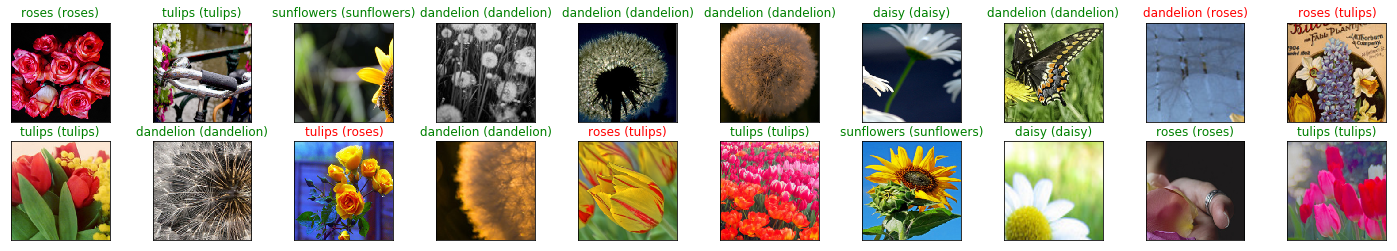

In [22]:
# obtain one batch of test images
dataiter = iter(loader_test)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy()) if train_on_gpu else np.squeeze(preds_tensor.numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for ix in np.arange(20):
    ax = fig.add_subplot(2, 20/2, ix+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[ix], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[ix]], classes[labels[ix]]),
                 color=("green" if preds[ix] == labels[ix].item() else "red"))